# A/B Test Analysis: Premium Offer Page Conversion Optimization

## Business Context

Lit Lantern is a mobile e-book and audiobook app using a freemium model with a 7-day premium trial. The company wants to increase conversion rates from free users to premium trial sign-ups.

*fictional situation generated with AI*

**The Test:**
The product team redesigned the premium offer page, hypothesizing that a clearer value proposition and improved visual design would increase trial sign-up rates.

- **Control (Variant A):** Original premium offer page
- **Treatment (Variant B):** Redesigned premium offer page with enhanced messaging and layout

## Metrics

### Primary Metric
- **Conversion Rate:** Percentage of users who initiated a premium trial after viewing the offer page

### Guardrail Metrics (Secondary Metrics)
We monitor these metrics to ensure the redesign doesn't negatively impact overall user behavior:
- **Session Duration per User:** Average time spent in the app per session
- **Average Number of Sessions per User:** User engagement frequency

## Hypothesis

**Null Hypothesis (H₀):** There is no difference in conversion rates between Variant A and Variant B

**Alternative Hypothesis (H₁):** Variant B will achieve at least a 5% higher conversion rate compared to Variant A

- **Significance Level (α):** 0.05
- **Statistical Power (1-β):** 0.80
- **Minimum Detectable Effect:** 5% relative improvement in conversion rate

## Test Design

### Sample Size Calculation

Sample size was calculated based on:
- Baseline conversion rate from historical data
- Minimum detectable effect of 5%
- Significance level (α) = 0.05
- Statistical power = 0.80

In [35]:
import numpy as np
from statsmodels.stats.power import NormalIndPower, tt_ind_solve_power
import statsmodels.api as sm
import statsmodels.stats.api as sms
from math import ceil

baseline_ctr = 0.3
mde = 0.05
alpha = 0.05 
power = 0.8 
 
effect_size = sm.stats.proportion_effectsize(baseline_ctr, baseline_ctr+ mde)
sample_size_per_group = NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)

print('Minimum sample size per group is: ' + str(ceil(sample_size_per_group)))

Minimum sample size per group is: 1376


### Test Duration

When choosing the test duration, it's important to calculate the number of randomization units. Additionally, we need to consider potential changes in weekly and monthly activity. Therefore, even if the sample size is small, we should avoid a test duration of less than a week.

## Analyzing Results

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data_control = pd.read_csv('ab_control.csv')
data_control.head()

,user_id,date,conversion,sessions_duration,sessions_number
0,1,2024-06-24,0,44.485905,3
1,2,2024-06-24,1,24.997178,2
2,3,2024-06-24,0,27.349969,2
3,4,2024-06-29,0,40.564806,6
4,5,2024-06-29,1,28.508229,5


In [11]:
data_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            1376 non-null   int64  
 1   date               1376 non-null   object 
 2   conversion         1376 non-null   int64  
 3   sessions_duration  1376 non-null   float64
 4   sessions_number    1376 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 53.9+ KB


In [12]:
data_control['group'] = 'A'

In [13]:
data_variant = pd.read_csv('ab_variant.csv')
data_variant.head()

,user_id,date,conversion,sessions_duration,sessions_number
0,1,2024-06-27,0,42.097980,1
1,2,2024-06-30,1,37.344819,6
2,3,2024-06-25,1,54.269020,7
3,4,2024-06-28,0,35.468540,3
4,5,2024-06-29,0,24.950643,9


In [14]:
data_variant['group'] = 'B'

In [15]:
data = pd.concat([data_control, data_variant])

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2752 entries, 0 to 1375
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            2752 non-null   int64         
 1   date               2752 non-null   datetime64[ns]
 2   conversion         2752 non-null   int64         
 3   sessions_duration  2752 non-null   float64       
 4   sessions_number    2752 non-null   int64         
 5   group              2752 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 150.5+ KB


In [17]:
data['date'] = pd.to_datetime(data['date'])

### Sample Ratio check

In [50]:
data.groupby('group').user_id.count()

group
A    1376
B    1376
Name: user_id, dtype: int64

### Users per day

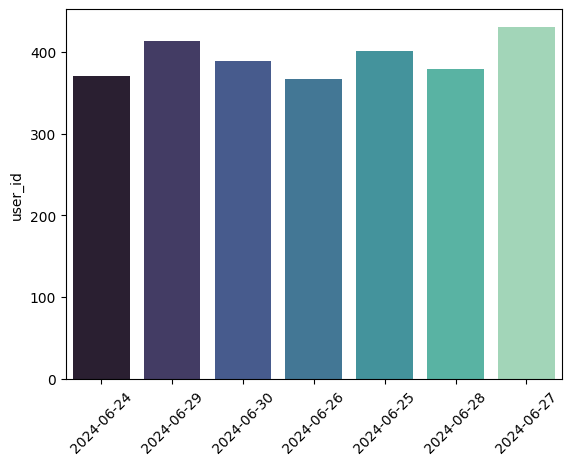

In [51]:
sns.barplot(x = data.date.unique().date, y = data.groupby('date').user_id.count(), palette='mako', 
            hue=data.date.unique().date, legend=False)
ticks = plt.xticks(rotation=45)

<Axes: xlabel='group', ylabel='conversion'>

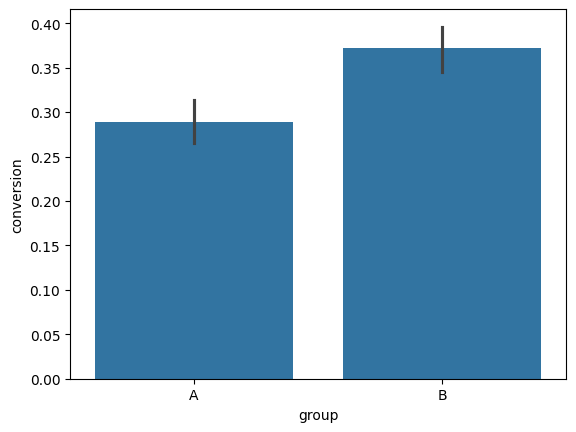

In [52]:
sns.barplot(x="group", y="conversion", data=data, estimator=np.average)

### Test analysis

In [53]:
from scipy import stats
std_p = lambda x:np.std(x)
stde_p = lambda x: stats.sem(x, ddof=0)

cr = data.groupby("group")["conversion"].agg(mean="mean", std=std_p, stde=stde_p)
cr.columns = ['mean', 'std', 'stde']
cr

,mean,std,stde
group,,,
A,0.288517,0.453073,0.012214
B,0.372093,0.483363,0.013031


In [72]:
conversions_control = data[data.group=='A'].conversion.sum()
n_control = len(data[data.group=='A'])

conversions_variant = data[data.group=='B'].conversion.sum()
n_variant = len(data[data.group=='B'])

rate_control = conversions_control / n_control
rate_variant = conversions_variant / n_variant

print(f"Control (A):  {conversions_control} / {n_control} = {rate_control:.2%}")
print(f"Variant (B):  {conversions_variant} / {n_variant} = {rate_variant:.2%}")
print(f"Absolute Difference: {(rate_variant - rate_control):.2%} ")
print(f"Relative Improvement: {((rate_variant - rate_control)/rate_control):.2%}%")

Control (A):  397 / 1376 = 28.85%
Variant (B):  512 / 1376 = 37.21%
Absolute Difference: 8.36% 
Relative Improvement: 28.97%%


In [63]:
z_score, p_value = sm.stats.proportions_ztest([conversions_control, conversions_variant], 
                                               [n_control, n_variant])

print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.6f}")

Z-score: -4.6610
P-value: 0.000003


The p-value is less than the significance level (p < 0.05), so we can reject the null hypothesis with 95% confidence.

In [64]:
ci_lower, ci_upper = sm.stats.proportion_confint([conversions_control, conversions_variant],
                                                   [n_control, n_variant],
                                                   alpha=0.05,
                                                   method='normal')

print(f"Control (A):  [{ci_lower[0]:.1%}, {ci_upper[0]:.1%}]")
print(f"Variant (B):  [{ci_lower[1]:.1%}, {ci_upper[1]:.1%}]")

Control (A):  [26.5%, 31.2%]
Variant (B):  [34.7%, 39.8%]


The CI intervals are not overlapping, so we can conclude that this result has practical significance.

### Secondary metrics

<Axes: xlabel='group', ylabel='sessions_duration'>

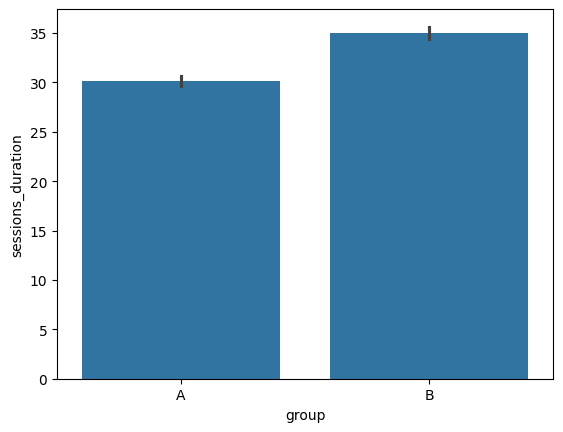

In [42]:
sns.barplot(x="group", y="sessions_duration", data=data, estimator=np.mean)

In [43]:
data.groupby('group').sessions_duration.mean()

group
A    30.136411
B    35.029648
Name: sessions_duration, dtype: float64

The average session duration has increased

<Axes: xlabel='group', ylabel='sessions_number'>

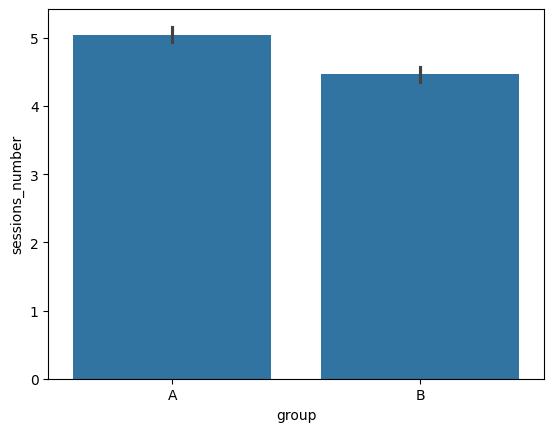

In [46]:
sns.barplot(x="group", y="sessions_number", data=data, estimator=np.mean)

In [47]:
data.groupby('group').sessions_number.mean()

group
A    5.049419
B    4.468750
Name: sessions_number, dtype: float64

The number of sessions has reduced. However, the difference between the control and variant groups is small, which we can attribute to the increased session duration.

## Summary of Findings

### Primary Metric: Conversion Rate

By statistical test, we can conclude that the difference between conversion rate in the control and variant groups is statistically and practically significant. Additionally, our assessment indicates that the secondary metrics did not exhibit a substantial negative impact. Therefore, based on these findings, we propose that it would be advisable to proceed with the implementation of the new feature.